## Quantum Walk
A quantum walk is a quantum mechanical counterpart to classical random walks, where a quantum system evolves over a graph-like structure.

Objective
This quantum program aims to simulate a quantum random walk on a linear topology consisting of 16 nodes.

Description of Linear Topology
- The walker can move between nodes with defined probabilities.
- For instance, from node 0, the walker can move to node 1, and from node 15, it can move to node 14. Nodes in between offer an equal chance to move left or right.

![Screenshot 2024-07-25 211733.png](<attachment:Screenshot 2024-07-25 211733.png>)
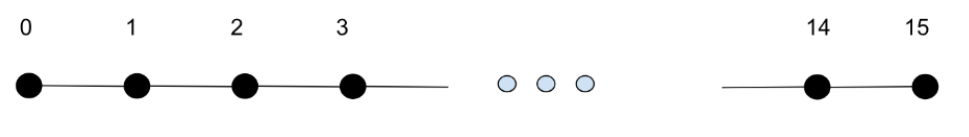

## Implementation

In [7]:
from classiq import *

In [2]:
size = 4 # qubit number (log2 of 16 nodes)
nodes = 2**size # (16 nodes)

## Probability Operator
This functions like flipping a quantum coin to decide how likely the walker is to move left or right from each node. It sets the probabilities for these movements based on the current node's position as defined above in the topology section

In [3]:
#initialize qubit in minus state
@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)

@qfunc
def diff_oracle(aux: Output[QNum],x:QNum):
    aux^=(x!=0)

# Combines prepare_minus and diffuzer_oracle to apply the diffusion operation conditioned on the state being different from zero.
@qfunc
def z_diff(x: QNum):
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diff_oracle)
    
#Defines the quantum walk step for a single node in the line. It prepares the probability vector and applies the diffusion and oracle operations.
def c_iter(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]  
    if i == 0:
        prob[i + 1] = 1.0  
    elif i == nodes - 1:
        prob[i - 1] = 1.0  
    else:
        prob[i - 1] = 0.5  
        prob[i + 1] = 0.5  
    print(f'Node={i}, prob vec ={prob}')
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: z_diff(adjacent_vertices)))
    
#Iterates over all nodes (from 0 to 15) and applies c_iter to each.
@qfunc 
def c_op(vertices:QNum, adjacent_vertices: QNum):
    for i in range(nodes):
        c_iter(i,vertices,adjacent_vertices)

## Make a Move
The operator facilitates movement by swapping the walker's state between nodes based on set probabilities. 

In [4]:
# Marks an edge condition based on the sum of two nodes being odd, connection between adjacent edges
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))

@qfunc
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    repeat(count= x.len,
        iteration= lambda i: SWAP(x[i],y[i]))
    
#Applies the edge oracle conditionally to perform the bitwise swap operation.
@qfunc 
def s_op(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))


In [5]:
@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    allocate(size,vertices)
    hadamard_transform(vertices)
    allocate(size,adjacent_vertices)
    c_op(vertices,adjacent_vertices)
    s_op(vertices,adjacent_vertices)

In [6]:
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Node=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node

## Synthesized Circuit
![6.12 circuit.jpg](<attachment:6.12 circuit.jpg>)

Depth: 5509 Width: 37
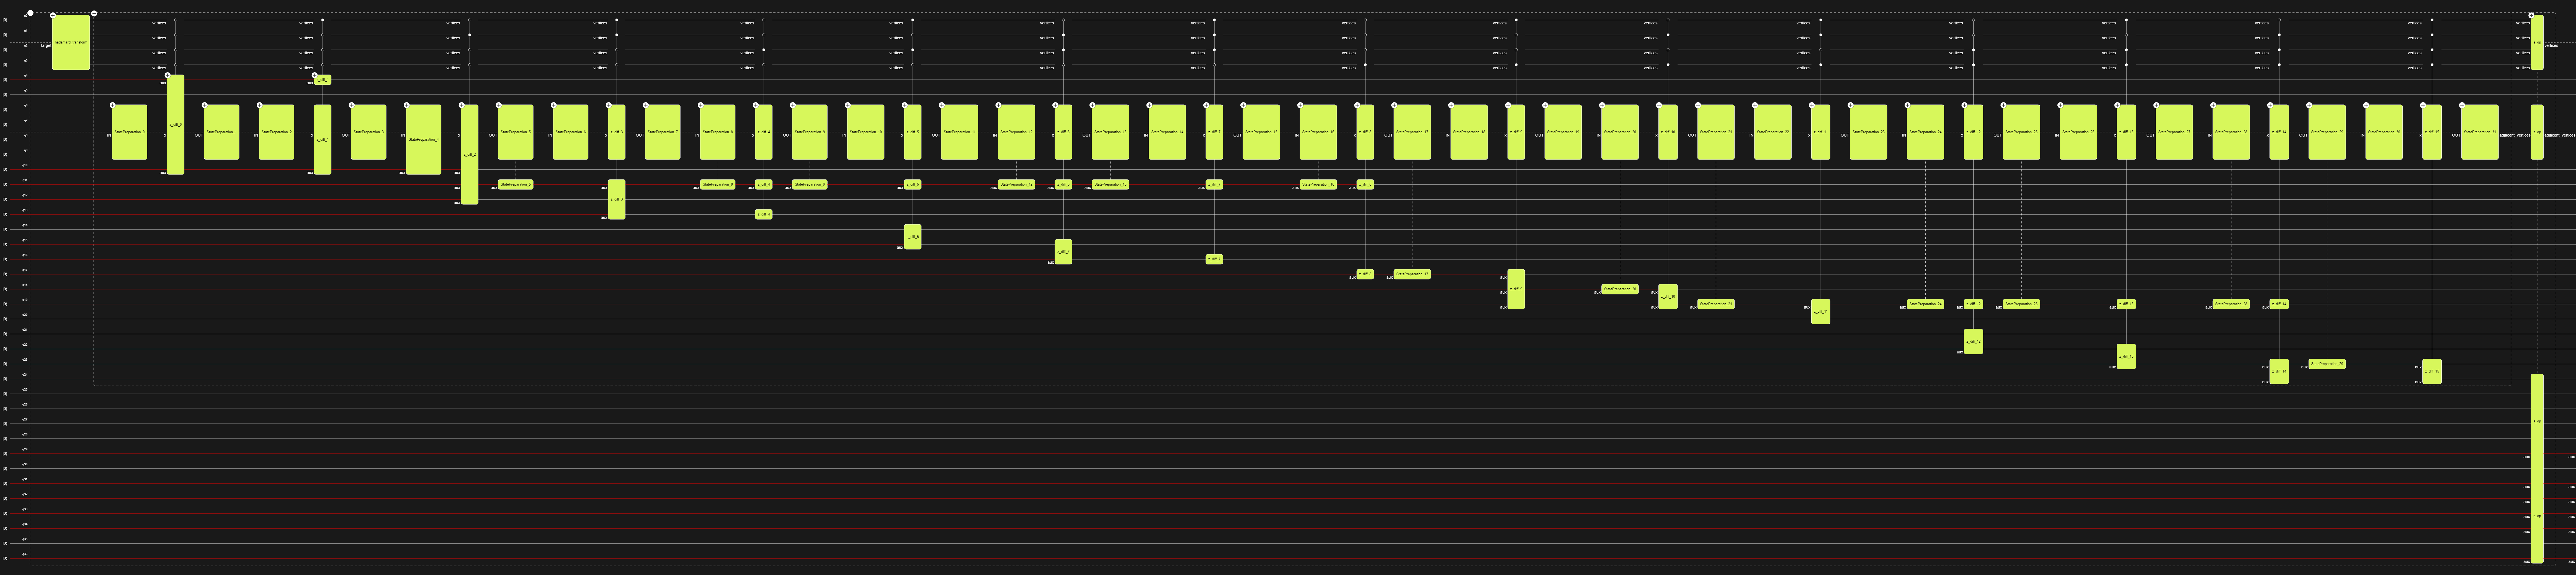